**Imports**

In [1]:
# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns

# Goggle
from goggle.GoggleModel import GoggleModel

# Synthcity
from synthcity.plugins.core.dataloader import GenericDataLoader

/home/dariusbarsony/anaconda3/envs/goggle_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


**Load data**

In [2]:
dataset = "white_wine"
X = pd.read_csv("../data/winequality-white.csv", sep=';')
ind = list(range(len(X.columns)))

ind = [x for x in ind if x != X.columns.get_loc("quality")]
col_list = X.columns[ind]
ct = ColumnTransformer(
    [("scaler", StandardScaler(), col_list)], remainder="passthrough"
)

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152,6.0
1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276,6.0
2,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667,6.0
3,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,6.0
4,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,6.0


**Fit model**

In [3]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)

gen = GoggleModel(
    ds_name=dataset,
    input_dim=X_train.shape[1],
    encoder_dim=64,
    encoder_l=2,
    het_encoding=True,
    decoder_dim=64,
    decoder_l=2,
    threshold=0.05,
    decoder_arch="gcn",
    graph_prior=None,
    prior_mask=None,
    device="cpu",
    beta=0.01,
    learning_rate=0.01,
    seed=0,
)
gen.model

Goggle(
  (learned_graph): LearnedGraph(
    (act): Sigmoid()
    (threshold): Threshold(threshold=0.05, value=0)
  )
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): ReLU()
    )
    (encode_mu): Linear(in_features=64, out_features=12, bias=True)
    (encode_logvar): Linear(in_features=64, out_features=12, bias=True)
  )
  (graph_processor): GraphInputProcessorHomo()
  (decoder): GraphDecoderHomo(
    (decoder): Sequential(
      (0): GraphConv(
        in=64, out=32, normalization=both
        (_activation): Tanh()
      )
      (1): GraphConv(in=32, out=1, normalization=both, activation=None)
    )
  )
)

In [4]:
gen.fit(X_train)

[Epoch 100/1000, patience  5] train: 4.516, val: 4.504
[Epoch 200/1000, patience  0] train: 3.410, val: 3.428
[Epoch 300/1000, patience  8] train: 2.724, val: 2.807
Training terminated after 383 epochs


**Evaluate synthetic data**

In [11]:
X_synth = gen.sample(X_test)
X_synth.head()

ValueError: Shape of passed values is (980, 12), indices imply (980, 13)

In [6]:
X_synth_loader = GenericDataLoader(
    X_synth,
    target_column="quality",
)
X_test_loader = GenericDataLoader(
    X_test,
    target_column="quality",
)

res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)
print(f"Quality: {res[0]:.3f}")
print(f"Detection: {res[2]:.3f}")
print(
    f"Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}, diff: {(res[1][0] - res[1][1]):.3f}"
)

cache loaded
cache loaded
cache loaded


Quality: 0.621
Detection: 0.737
Performance on real: 0.168, on synth: -0.452, diff: 0.620


**Generate TSNE plots**

In [7]:
X_test["label"] = "Original"
X_synth["label"] = "Synthetic"

concat_df = pd.concat([X_test, X_synth], axis=0)
y_data = concat_df["label"]
x_data = concat_df.drop(["label", "quality"], axis=1)

In [8]:
tsne = TSNE(n_components=2, verbose=0, random_state=0)
z = tsne.fit_transform(x_data)
df = pd.DataFrame()
df["y"] = y_data
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

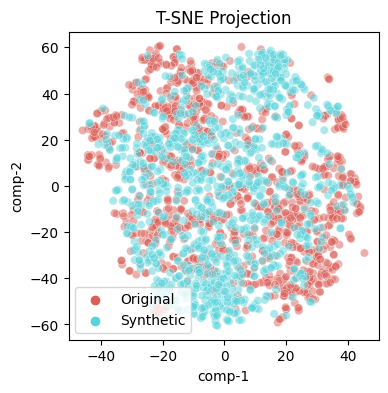

In [9]:
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x="comp-1",
    y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),
    alpha=0.5,
    data=df,
).set(title=f"T-SNE Projection")
plt.xlabel("comp-1")
plt.ylabel("comp-2")
plt.legend()

plt.show()

**Visualise adjacency matrix**

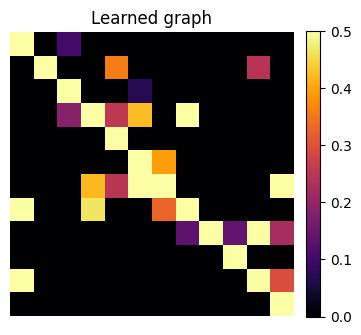

In [10]:
adj_matrix = gen.model.learned_graph(100).cpu().detach().numpy()
plt.figure(figsize=(4, 4))
im = plt.imshow(adj_matrix, cmap="inferno", interpolation="nearest", vmin=0, vmax=0.5)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Learned graph")
plt.axis("off")
plt.show()